In [19]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras import layers
import numpy as np
from keras.callbacks import EarlyStopping
from tensorflow import nn
from sklearn.preprocessing import normalize
from glob import glob
import os
from tensorflow.keras.models import load_model

In [20]:
HEIGHT = 384
WIDTH = 576
trainFile = '03- train- Img only'
testFile = '04- test- Img only'
BATCH_SIZE = 32
nextEpoch = 54
path = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training"

In [21]:
unet_model = load_model("W:/Advanced Engineering/Vortex Ballistics/~ACTIVE/Python Script/models/model 10-27_Ring Mask-105 epochs-582 images/53.h5")

In [22]:
seed = 42
BATCH_SIZE = 32
inputDataGen2 = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  zoom_range=0.2,
                                  fill_mode='nearest',
                                  )
#inputDataGen = ImageDataGenerator(rescale=1./255)

# inGen = inputDataGen.flow_from_directory(path + '\\01- train\\Input', batch_size=32, class_mode=None, seed=seed, color_mode='grayscale')
# outGen = inputDataGen.flow_from_directory(path + '\\01- train\\Ring Mask', batch_size=32, class_mode=None, seed=seed, color_mode='grayscale')
inGen = inputDataGen2.flow_from_directory(path + '\\03- train- Img only\\Input', batch_size=BATCH_SIZE, target_size=(HEIGHT, WIDTH), class_mode=None, seed=seed, color_mode='grayscale')
outGen = inputDataGen2.flow_from_directory(path + '\\03- train- Img only\\Ring Mask', batch_size=BATCH_SIZE, target_size=(HEIGHT, WIDTH), class_mode=None, seed=seed, color_mode='grayscale')

sampleSize = inGen.samples

train_generator = zip(inGen, outGen)

Found 582 images belonging to 1 classes.


Found 582 images belonging to 1 classes.


In [23]:
# inGen = outputDataGen.flow_from_directory(path + '\\02- test\\Input', batch_size=32, class_mode=None, seed=seed, color_mode='grayscale')
# outGen = outputDataGen.flow_from_directory(path + '\\02- test\\Ring Mask', batch_size=32, class_mode=None, seed=seed, color_mode="grayscale")
inGen = inputDataGen2.flow_from_directory(path + '\\04- test- Img only\\Input', batch_size=BATCH_SIZE, target_size=(HEIGHT, WIDTH), class_mode=None, seed=seed, color_mode='grayscale')
outGen = inputDataGen2.flow_from_directory(path + '\\04- test- Img only\\Ring Mask', batch_size=BATCH_SIZE, target_size=(HEIGHT, WIDTH), class_mode=None, seed=seed, color_mode="grayscale")

test_generator = zip(inGen, outGen)

Found 198 images belonging to 1 classes.
Found 198 images belonging to 1 classes.


In [24]:
class OutputPrinting(keras.callbacks.Callback):
    testFile1 = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training/00- Full Image Dataset\IMG_00703.JPG"
    testFile2 = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training/00- Full Image Dataset\IMG_00827.JPG"
    testFile3 = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training/00- Full Image Dataset\IMG_003.JPG"
    imgArr = [testFile1, testFile2, testFile3]
    
    def on_epoch_end(self, batch, logs=None):
        keys = list(logs.keys())
        
        fig = plt.figure(figsize=(3,2))

        for i in range(len(self.imgArr)):
            testImg = image.load_img(self.imgArr[i], color_mode='grayscale')
            testImg = np.expand_dims(testImg, axis=0)
            testImg = testImg/255
            imOut = self.model.predict(testImg)
            imOut = imOut.reshape(testImg.shape[1:3])
            testImg = testImg.reshape(testImg.shape[1:3])
            plt.subplot(3, 2, 2*i+1)
            plt.imshow(testImg, cmap='gray')
            plt.subplot(3, 2, 2*i+2)
            plt.imshow(imOut, cmap='gray')
            plt.axis('off')

        plt.show()

In [25]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):

    def __init__(self, patience=100):
        super().__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None
        self.model_location = "W:\Advanced Engineering\Vortex Ballistics\~ACTIVE\Python Script\models\model 10-27_Ring Mask-105 epochs-582 images"

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        self.model.save(self.model_location + '/' + str(nextEpoch + epoch) + '.h5')
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()    
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)
        # if current < 0.023:
        #     tf.keras.backend.set_value(self.model.optimizer.lr, 1e-6)
        #     print("\nEpoch %05d: Learning rate is %6.8f." % (epoch, 1e-6))
        # if current < 0.020:
        #     tf.keras.backend.set_value(self.model.optimizer.lr, 1e-8)
        #     print("\nEpoch %05d: Learning rate is %6.8f." % (epoch, 1e-8))
        if current < 0.020:
            tf.keras.backend.set_value(self.model.optimizer.lr, 1e-10)
            print("\nEpoch %05d: Learning rate is %6.9f." % (epoch, 1e-10))

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

In [26]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-8),
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                   #loss = 'mse',
                   metrics=["accuracy"])

es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1, restore_best_weights=False)

Epoch 1/56
1/1 [==============================] - 1s 1s/step


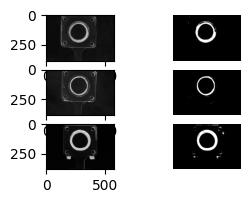

18/18 [==============================] - 2889s 161s/step - loss: 0.0191 - accuracy: 0.9644 - val_loss: 0.0220 - val_accuracy: 0.9640
Epoch 2/56
1/1 [==============================] - 1s 938ms/step


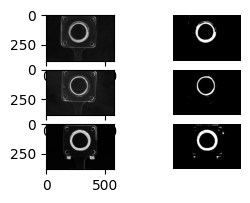

18/18 [==============================] - 2596s 151s/step - loss: 0.0194 - accuracy: 0.9640 - val_loss: 0.0227 - val_accuracy: 0.9635
Epoch 3/56
1/1 [==============================] - 1s 955ms/step


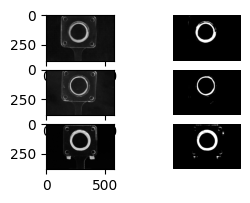

18/18 [==============================] - 2189s 122s/step - loss: 0.0193 - accuracy: 0.9642 - val_loss: 0.0229 - val_accuracy: 0.9634
Epoch 4/56
1/1 [==============================] - 1s 921ms/step


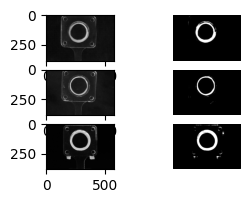

18/18 [==============================] - 2354s 131s/step - loss: 0.0192 - accuracy: 0.9644 - val_loss: 0.0226 - val_accuracy: 0.9635
Epoch 5/56
1/1 [==============================] - 1s 897ms/step


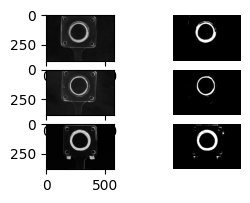

18/18 [==============================] - 2706s 151s/step - loss: 0.0190 - accuracy: 0.9644 - val_loss: 0.0223 - val_accuracy: 0.9639
Epoch 6/56
1/1 [==============================] - 1s 952ms/step


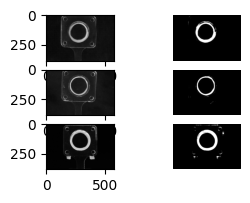

18/18 [==============================] - 2706s 150s/step - loss: 0.0191 - accuracy: 0.9645 - val_loss: 0.0222 - val_accuracy: 0.9640
Epoch 7/56
1/1 [==============================] - 1s 948ms/step


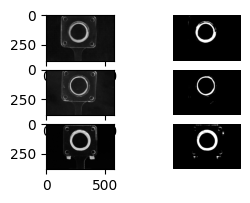

18/18 [==============================] - 2272s 126s/step - loss: 0.0193 - accuracy: 0.9645 - val_loss: 0.0228 - val_accuracy: 0.9637
Epoch 8/56
1/1 [==============================] - 1s 956ms/step


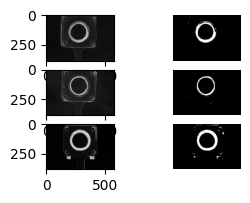

18/18 [==============================] - 2071s 115s/step - loss: 0.0192 - accuracy: 0.9644 - val_loss: 0.0230 - val_accuracy: 0.9631
Epoch 9/56
1/1 [==============================] - 1s 948ms/step


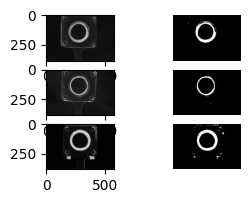

18/18 [==============================] - 2118s 118s/step - loss: 0.0193 - accuracy: 0.9643 - val_loss: 0.0222 - val_accuracy: 0.9642
Epoch 10/56
1/1 [==============================] - 1s 927ms/step


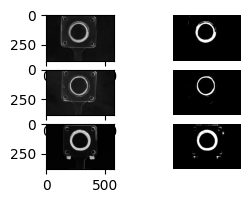

18/18 [==============================] - 2203s 123s/step - loss: 0.0187 - accuracy: 0.9649 - val_loss: 0.0225 - val_accuracy: 0.9641
Epoch 11/56
1/1 [==============================] - 1s 974ms/step


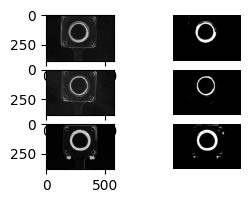

18/18 [==============================] - 2168s 121s/step - loss: 0.0192 - accuracy: 0.9647 - val_loss: 0.0230 - val_accuracy: 0.9633
Epoch 12/56
1/1 [==============================] - 1s 918ms/step


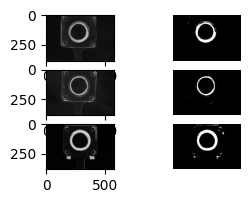

18/18 [==============================] - 2153s 120s/step - loss: 0.0188 - accuracy: 0.9647 - val_loss: 0.0232 - val_accuracy: 0.9632
Epoch 13/56
1/1 [==============================] - 1s 1s/step


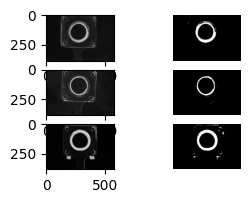

18/18 [==============================] - 2136s 119s/step - loss: 0.0195 - accuracy: 0.9641 - val_loss: 0.0220 - val_accuracy: 0.9646
Epoch 14/56
1/1 [==============================] - 1s 961ms/step


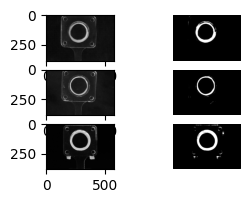

18/18 [==============================] - 2157s 120s/step - loss: 0.0189 - accuracy: 0.9648 - val_loss: 0.0227 - val_accuracy: 0.9639
Epoch 15/56
1/1 [==============================] - 1s 911ms/step


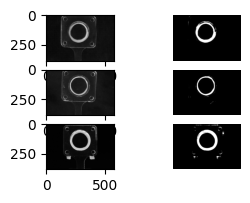

18/18 [==============================] - 2167s 121s/step - loss: 0.0192 - accuracy: 0.9644 - val_loss: 0.0228 - val_accuracy: 0.9636
Epoch 16/56
1/1 [==============================] - 1s 926ms/step


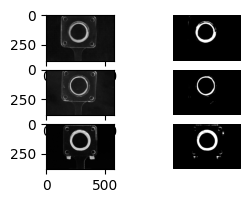

18/18 [==============================] - 2162s 120s/step - loss: 0.0192 - accuracy: 0.9642 - val_loss: 0.0221 - val_accuracy: 0.9643
Epoch 17/56
1/1 [==============================] - 1s 930ms/step


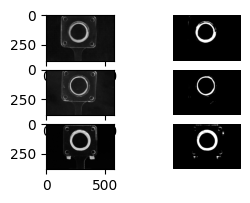

18/18 [==============================] - 2195s 123s/step - loss: 0.0190 - accuracy: 0.9646 - val_loss: 0.0229 - val_accuracy: 0.9635
Epoch 18/56
1/1 [==============================] - 1s 946ms/step


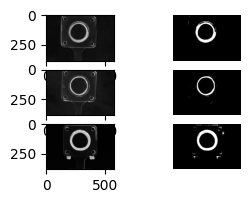

18/18 [==============================] - 2171s 121s/step - loss: 0.0191 - accuracy: 0.9646 - val_loss: 0.0225 - val_accuracy: 0.9640
Epoch 19/56
1/1 [==============================] - 1s 892ms/step


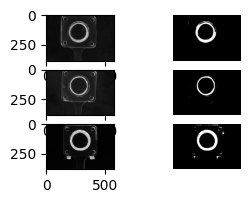

18/18 [==============================] - 2243s 125s/step - loss: 0.0191 - accuracy: 0.9645 - val_loss: 0.0227 - val_accuracy: 0.9635
Epoch 20/56
1/1 [==============================] - 1s 973ms/step


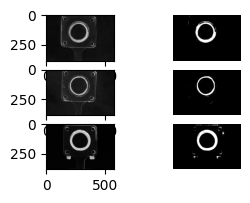

18/18 [==============================] - 2313s 129s/step - loss: 0.0193 - accuracy: 0.9642 - val_loss: 0.0228 - val_accuracy: 0.9635
Epoch 21/56
1/1 [==============================] - 1s 912ms/step


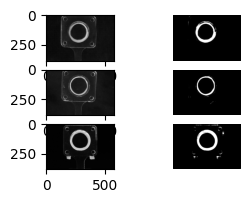

18/18 [==============================] - 2248s 131s/step - loss: 0.0192 - accuracy: 0.9644 - val_loss: 0.0225 - val_accuracy: 0.9637
Epoch 22/56
1/1 [==============================] - 1s 909ms/step


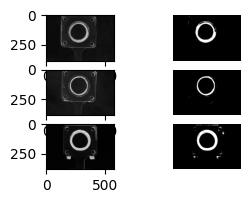

18/18 [==============================] - 2250s 125s/step - loss: 0.0192 - accuracy: 0.9645 - val_loss: 0.0231 - val_accuracy: 0.9633
Epoch 23/56
1/1 [==============================] - 1s 909ms/step


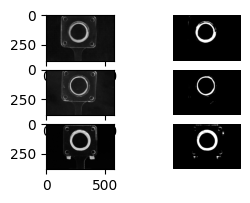

18/18 [==============================] - 2268s 126s/step - loss: 0.0191 - accuracy: 0.9645 - val_loss: 0.0226 - val_accuracy: 0.9640
Epoch 24/56
1/1 [==============================] - 1s 970ms/step


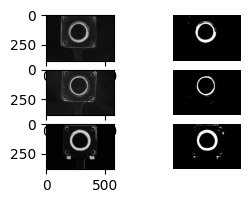

18/18 [==============================] - 2277s 127s/step - loss: 0.0190 - accuracy: 0.9647 - val_loss: 0.0223 - val_accuracy: 0.9639
Epoch 25/56
1/1 [==============================] - 1s 984ms/step


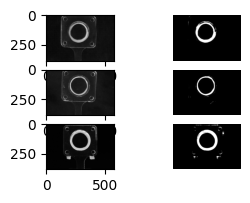

18/18 [==============================] - 2362s 132s/step - loss: 0.0189 - accuracy: 0.9648 - val_loss: 0.0229 - val_accuracy: 0.9636
Epoch 26/56
16/18 [=========================>....] - ETA: 4:19 - loss: 0.0191 - accuracy: 0.9648

KeyboardInterrupt: 

In [27]:
BUFFER_SIZE = 1000
NUM_EPOCHS = 110 - nextEpoch

TRAIN_LENGTH = 213
#STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
STEPS_PER_EPOCH = 13

VAL_SUBSPLITS = 5
TEST_LENTH = 27
#VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
VALIDATION_STEPS = 5

#model_history = unet_model.fit(train_generator,
#                               epochs=NUM_EPOCHS,
#                               steps_per_epoch= sampleSize//BATCH_SIZE,
#                               validation_steps=VALIDATION_STEPS,
#                               validation_data=test_generator,
#                               #callbacks=[es]
#                              )

model_history = unet_model.fit(train_generator,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch= sampleSize//BATCH_SIZE,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=test_generator,
                               callbacks=[OutputPrinting(), EarlyStoppingAtMinLoss()]
                               )